In [1]:
import numpy as np
from scipy.optimize import nnls
import itertools as itt
import networkx as nx
import matplotlib.pyplot as plt
from mixsol.mixsol import Mixer, SolutionMaker
from mixsol.solution import Solution, Powder, calculate_molar_mass
from molmass import Formula


In [3]:
powders = [
    Powder(
        formula='Cs_I',
    ),
    Powder(
        formula='Pb_I2',
    ),
    Powder(
        formula='Pb_Br2'
    ),
    Powder(
        formula='Pb_Cl2'
    ),
    Powder(
        'MA_I',
        molar_mass=calculate_molar_mass('C_H6_N_I'),
        alias='MAI',
    ),
    Powder(
        'FA_I',
        molar_mass = calculate_molar_mass('C_H5_N2_I'),
        alias='FAI',
        )
]

maker = SolutionMaker(
    powders=powders
)

In [4]:
target=Solution(
    solutes='Cs0.8_FA0.2_Pb_I0.8_Br2.4',
    solvent='DMF9_DMS01',
    molarity=1
)

maker.get_weights(
    target,
    volume=1e-3 #in mL
)

{<Powder>Cs_I: 0.1905272761040001,
 <Powder>Pb_Br2: 0.42572811999999977,
 <Powder>FAI: 0.024261757199999963}

In [14]:
0.2598/powders[0].molar_mass

0.0009999618106963537

In [7]:
target.solute_dict

{'DMF': 9.0, 'DMS': 1.0}

In [6]:
maker._solution_to_vector(target, 1e-3)

array([0., 0., 0.])

In [2]:
stock_solutions = [
    Solution(
        solutes='FA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1,
        alias='FAPI'
    ),
    Solution(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1,
        alias='MAPI'
    ),
    
]

# densetargets = []
# for a in np.logspace(0, -3, 10):
#     densetargets.append(Solution(
#         solutes=f"FA{a:0.3f}_MA{1-a:.3f}_Pb_I3",
#         solvent="DMF9_DMSO1",
#         molarity=1,
#         alias=f'FA_{a:.3f}'
#     ))


densetargets = []
for a in np.linspace(0, 0.8, 10):
    densetargets.append(Solution(
        solutes=f"FA{a:0.3f}_MA{1-a:.3f}_Pb_I3",
        solvent="DMF9_DMSO1",
        molarity=1,
        alias=f'FA_{a:.3f}'
    ))

In [3]:
sm = Mixer(stock_solutions, {t:60 for t in densetargets})

In [4]:
sm.solve(min_volume=20, max_inputs = 3)

In [5]:
sm.print()

===== Stock Prep =====
240.00 of FAPI
360.00 of MAPI
====== Mixing =====
Distribute FAPI:
	153.67 to FA_0.622
	86.33 to FA_0.800
Distribute MAPI:
	93.39 to FA_0.622
	74.82 to FA_0.444
	71.84 to FA_0.178
	29.94 to FA_0.267
	30.00 to FA_0.089
Distribute FA_0.622:
	96.99 to FA_0.800
	30.00 to FA_0.711
	60.07 to FA_0.533
Distribute FA_0.800:
	30.00 to FA_0.711
	93.32 to FA_0.444
Distribute FA_0.444:
	60.07 to FA_0.533
	48.07 to FA_0.178
Distribute FA_0.533:
	30.06 to FA_0.267
	30.08 to FA_0.356
Distribute FA_0.178:
	30.00 to FA_0.089
	29.92 to FA_0.356


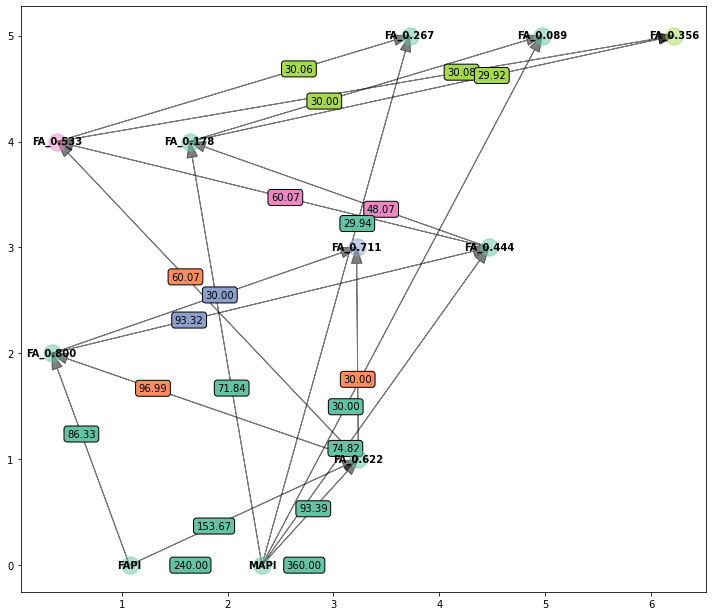

In [6]:
sm.plot()